In [1]:
import os
import sys
import gym
import pylab
import random 
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
from IPython import display
from IPython.display import clear_output
from matplotlib import animation

%matplotlib inline

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Class Deep Neural Net
class DQN(nn.Module):
    def __init__(self, input_shape, action_size):
        super().__init__()
        self.fc1 = nn.Linear(input_shape, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [3]:
# Replay Buffer
class ReplayMemory():
    def __init__(self, buffer_limit):
        self.memory = deque(maxlen=buffer_limit)
    
    def append_sample(self, transition):
        self.memory.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.memory, n)
        s_list, a_list, r_list, s_prime_list, done_mask_list = [], [], [], [], []
        
        for tr in mini_batch:
            s, a, r, s_prime, done_mask = tr
            s_list.append(s)
            a_list.append([a])
            r_list.append([r])
            s_prime_list.append(s_prime)
            done_mask_list.append([done_mask])
        
        return torch.tensor(s_list, dtype=torch.float).to(device), torch.tensor(a_list).to(device), torch.tensor(r_list).to(device), torch.tensor(s_prime_list, dtype=torch.float).to(device), torch.tensor(done_mask_list).to(device)
    
    def size(self):
        return len(self.memory)

In [14]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        
        #DQN Hyperparameter
        self.discount_factor = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.batch_size = 32
        self.train_start = 2000
        self.LEARNING_RATE = 0.001
        
        self.loss_list = [] 
        self.loss_mean_list = []
        
        self.q_mean_list = []
        
        # Setting Model
        self.model = DQN(state_size, action_size).to(device)
        self.target_model = DQN(state_size, action_size).to(device)
        
        self.update_target_model()
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.LEARNING_RATE)
        
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
        if len(self.loss_list) == 0:
            self.loss_mean_list.append(0.0)
        else:
            self.loss_mean_list.append(np.mean(self.loss_list))
            self.loss_list = []
    
    # Select Action
    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(action_size)
        else:
            q_value = self.model.forward(state)
            return torch.argmax(q_value).item()
        
    def train_model(self, memory): 
        # Decay the epsilon
        if self.epsilon >= self.epsilon_min:
            self.epsilon *= self.epsilon_decay     
        
        # Get the sample randomly from the replay memory
        states, actions, rewards, next_states, dones = memory.sample(self.batch_size)
        
        # 현재 상태에 대한 모델 Q함수
        q_values = self.model(states).gather(1, actions)
        self.q_mean_list.append(torch.mean(q_values).item())
        
        # 다음 상태에 대한 모델 Q함수
        max_q = self.target_model(next_states).max(1)[0].unsqueeze(1)
        targets = rewards + self.discount_factor*max_q*dones
        loss = nn.MSELoss()(q_values, targets)
        
        self.loss_list.append(loss.item())
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        

In [5]:
# Save frames as gif 
def save_frames_as_gif(frames, path='./', filename='gym_animation_v2.gif'):
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval = 10)
    
    anim.save(path + filename, writer='imagemagick', fps=36)

In [6]:
# Draw the plot 
def plot_d(episodes, y, x_lab, y_lab, path):
    pylab.plot(episodes, y, 'b')
    pylab.xlabel(x_lab)
    pylab.ylabel(y_lab)
    pylab.savefig(path)

episode:  10 | score : 29.00 | Average_score: 20.700 | epsilon: 1.0000
episode:  20 | score : 21.00 | Average_score: 21.200 | epsilon: 1.0000
episode:  30 | score : 13.00 | Average_score: 19.733 | epsilon: 1.0000
episode:  40 | score : 12.00 | Average_score: 19.525 | epsilon: 1.0000
episode:  50 | score : 26.00 | Average_score: 19.800 | epsilon: 1.0000
episode:  60 | score : 64.00 | Average_score: 21.217 | epsilon: 1.0000
episode:  70 | score : 10.00 | Average_score: 21.529 | epsilon: 1.0000
episode:  80 | score : 10.00 | Average_score: 21.125 | epsilon: 1.0000
episode:  90 | score : 45.00 | Average_score: 21.289 | epsilon: 1.0000
episode: 100 | score : 17.00 | Average_score: 21.190 | epsilon: 0.5480
episode: 110 | score : 18.00 | Average_score: 20.464 | epsilon: 0.2828
episode: 120 | score : 10.00 | Average_score: 19.658 | epsilon: 0.1646
episode: 130 | score : 68.00 | Average_score: 21.469 | epsilon: 0.0189
episode: 140 | score : 111.00 | Average_score: 26.593 | epsilon: 0.0100
episo

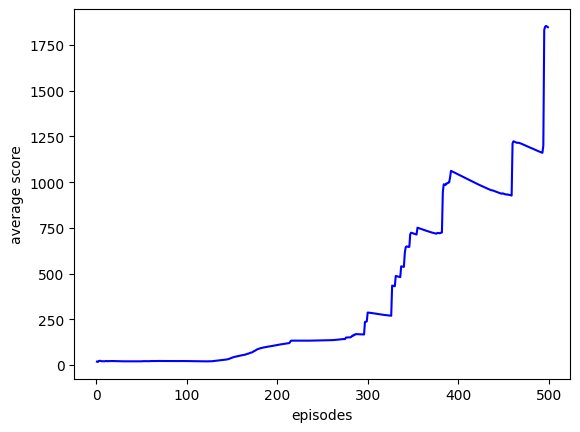

In [15]:
if __name__ == "__main__":
    env = gym.make("CartPole-v1")
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    
    agent = DQNAgent(state_size, action_size)
    
    scores, episodes = [], []
    score_total = 0
    
    num_episodes = 1000
    
    memory = ReplayMemory(20000)
    
    for e in range(1, num_episodes):
        
        done = False
        score = 0
        time = 0 
        
        state = env.reset()[0]
        
        while not done:
            
            # 현재 상태로 행동을 선택
            action = agent.select_action(torch.from_numpy(state).float())
            
            # 선택한 환경으로 다음 스텝 진행
            next_state, reward, done, info, _ = env.step(action)
            
            # 타임 스텝마다 보상 reward + time*0.01
            score += reward
            reward = reward + 0.01 * time
            done_mask = 0.0 if done else 1.0
                      
            # Save sample in replay memory
            memory.append_sample((state, action, reward, next_state, done_mask))
            
            # learning per time-step
            if memory.size() >= agent.train_start:
                agent.train_model(memory)
                
            state = next_state
            time += 1 
            #if score >= 10000:
            #    done = True
            
            
            if done: 
                # 각 에피스드마타 타깃 모델을 모델의 가중치로 업데이트
                agent.update_target_model()
                
                score_total += score 
                
                #에피소드마다 reward평균 저장
                scores.append(score_total/e)
                episodes.append(e)
                
                #출력 
                if e % 10 == 0:
                    print("episode: {:3d} | score : {:3.2f} | Average_score: {:.3f} | epsilon: {:.4f}".format(e, score, score_total/e, agent.epsilon))
                
    plot_d(episodes, scores, "episodes", "average score", "./graph.png")
    np.savetxt("./cartpole_DQN_reward.txt", scores)
    
    # Save the target model
    print("Saving trained model")
    torch.save(agent.target_model.state_dict(), "cartpole-dqn.pth")
    


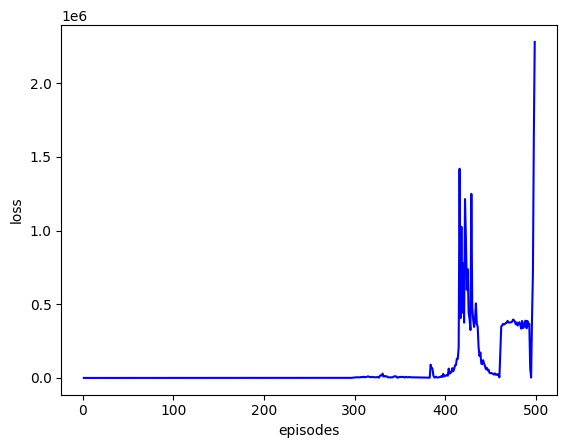

In [21]:
plot_d(episodes, agent.loss_mean_list[1:len(agent.loss_mean_list)], "episodes", "loss", "./dqn_loss.png")

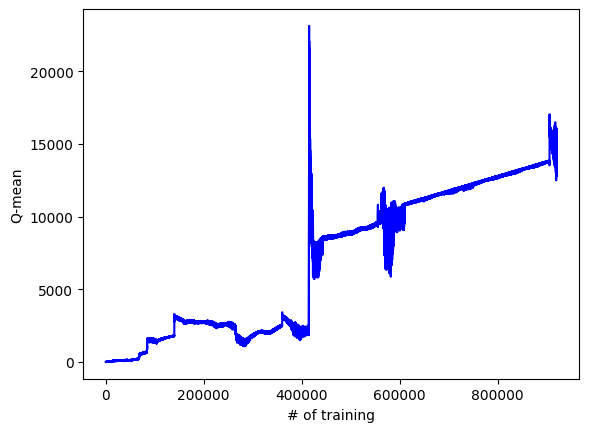

In [20]:
plot_d(range(len(agent.q_mean_list)), agent.q_mean_list, "# of training", "Q-mean", "./dqn_q.png")

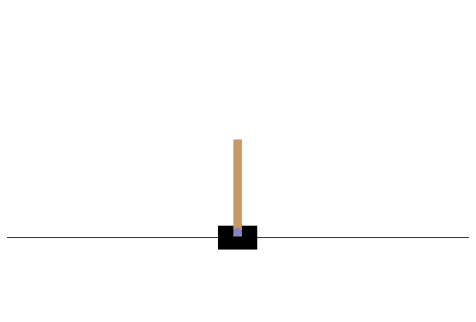

In [35]:
# Record actions of Catpole and save
env_rgb = gym.make("CartPole-v1", render_mode="rgb_array")
state = env_rgb.reset()[0]
frames = []

a = DQNAgent(state_size, action_size)
a.model.load_state_dict(torch.load("cartpole-dqn.pth"))

for t in tqdm(range(500)):
    frames.append(env_rgb.render())
    q_value = a.model.forward(torch.from_numpy(state).float())
    action = torch.argmax(q_value).item()
    state, _, done, _, _ = env_rgb.step(action)
    if done:
        break
save_frames_as_gif(frames)
clear_output(wait=True)
env.close()

/var/folders/2f/jywbtpbd4yn8zkj0rms9wttr0000gn/T/ipykernel_14039/885485721.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML



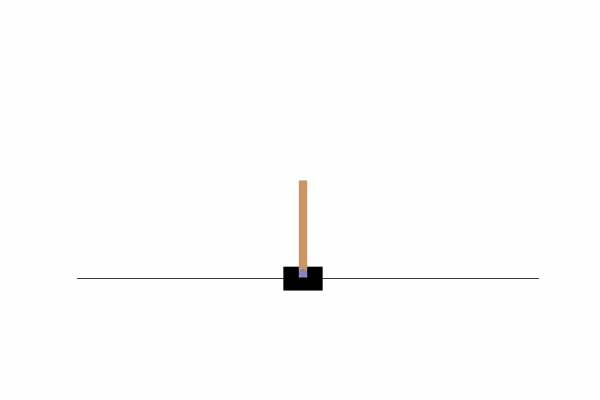

In [36]:
gif_file = './gym_animation_v2.gif'
import base64
from IPython.core.display import display, HTML
b64 = base64.b64encode(open(gif_file,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))